![clothing_classification](logo/wallpaper.png)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
from captum.attr import (
    GradientShap,
    DeepLift,
    IntegratedGradients
)

##### LOAD DATASET FROM INBUILT DATASET:

In [2]:
def load_fashion_mnist():
    """
    Loads the Fashion-MNIST dataset for both training and testing.
    
    Returns:
        tuple: (train_data, test_data)
            - train_data: FashionMNIST dataset with 60,000 training images
            - test_data: FashionMNIST dataset with 10,000 test images
            
    Dataset details:
        - Image size: 28x28 pixels (grayscale)
        - Images are automatically normalized to [0,1] range
        - Classes: 10 types of clothing items
    """
    train_data = datasets.FashionMNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

    test_data = datasets.FashionMNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

    return train_data, test_data


In [3]:
# **** BRING IN DATASET:
train_data, test_data = load_fashion_mnist()
print("Training dataset size:", len(train_data))
print("Test dataset size:", len(test_data))

Training dataset size: 60000
Test dataset size: 10000


In [4]:
# **** MODEL CONFIGURATION:
def get_model_config(train_data):
    """
    Args:
        train_data (Dataset): Training dataset
    Returns:
        dict: Model configuration parameters
    Raises:
        ValueError: If dataset is empty or malformed
    """
    if len(train_data) == 0:
        raise ValueError("Empty dataset provided")

    # Validate dataset has expected attributes
    if not hasattr(train_data, 'classes'):
        raise ValueError("Dataset missing 'classes' attribute")

    # Extract first image to validate shape
    first_image = train_data[0][0]
    if len(first_image.shape) != 3:
        raise ValueError(f"Expected 3D tensor for images (got {len(first_image.shape)}D)")

    height, width = first_image.shape[1:]
    if height != width:
        raise ValueError(f"Expected square images (got {height}x{width})")

    return {
        'num_classes': len(train_data.classes),
        'classes': train_data.classes,
        'num_input_channels': first_image.shape[0],
        'num_output_channels': 16,
        'image_size': height
    }


In [6]:
# **** MODEL DEFINITION:
class MultiClassImageClassifier(nn.Module):
    """
    A Convolutional Neural Network for multi-class image classification.
    
    Architecture:
        - Single convolutional layer with ReLU activation
        - MaxPooling for dimensionality reduction
        - Fully connected layer for final classification
    
    Args:
        num_classes (int): Number of output classes for classification
        
    Note:
        Assumes input images are single-channel (grayscale) with fixed dimensions
    """
    
    def __init__(self, config):
        """
        Args:
            config (dict): Configuration dictionary containing:
                - num_classes (int)
                - num_input_channels (int)
                - num_output_channels (int)
                - image_size (int)
        """
        super().__init__()

        self.input_channels = config['num_input_channels']
        self.output_channels = config['num_output_channels']
        self.image_size = config['image_size']

        # Input validation
        if not all(isinstance(v, int) for v in [self.input_channels,
                                              self.output_channels,
                                              self.image_size]):
            raise ValueError("Channel counts and image size must be integers")

        # Architecture with better stability
        self.conv1 = nn.Conv2d(self.input_channels, self.output_channels,
                              kernel_size=3, stride=1, padding=1)  #Convolutional layer with padding to maintain spatial dimensions
        self.bn1 = nn.BatchNorm2d(self.output_channels)
        self.relu = nn.ReLU() # ReLU activation function for non-linearity
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPooling layer reduces spatial dimensions by half
        self.dropout = nn.Dropout(0.25) 

        # Calculate flattened size
        flat_size = self.output_channels * (self.image_size//2)**2 # Flatten layer to convert 3D feature maps to 1D vector

        # Fully connected layer for final classification
        self.classifier = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, config['num_classes'])
        ) # Input size accounts for maxpool's reduction of spatial dimensions

    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width]
            
        Returns:
            torch.Tensor: Raw logits for each class, shape [batch_size, num_classes]
            
        Processing steps:
            1. Convolution + ReLU activation
            2. MaxPooling for spatial reduction
            3. Flatten to 1D
            4. Fully connected layer for classification
        """
        # Input validation
        if x.dim() != 4:
            raise ValueError(f"Expected 4D input (got {x.dim()}D)")
        if x.size(1) != self.input_channels:
            raise ValueError(
                f"Expected {self.input_channels} channels (got {x.size(1)})")

        x = self.conv1(x) # Apply convolution
        x = self.bn1(x) # Batch normalization
        x = self.relu(x) # Apply ReLU activation
        x = self.maxpool(x) # Reduce spatial dimensions
        x = self.dropout(x) # Dropout for regularization
        x = torch.flatten(x, 1) # Flatten to 1D
        x = self.classifier(x) # Final classification layer
        return x


In [7]:
# **** Device architecture: Verify if CUDA is available:
print(f"Is MPS (Apple Silicon GPU) available? {torch.backends.mps.is_available()}")

Is MPS (Apple Silicon GPU) available? True


In [9]:
class ModelInterpreter:
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device
        self.model.to(device)
        
    def plot_confusion_matrix(self, dataloader, class_names):
        """Generate and plot confusion matrix"""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for features, labels in dataloader:
                features = features.to(self.device)
                outputs = self.model(features)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return cm  # Return for further analysis if needed
        
    def visualize_layer_activations(self, input_tensor):
        """Visualize activations of convolutional layers"""
        self.model.eval()
        activations = {}
        
        def hook_fn(module, input, output):
            activations[module] = output.detach()
            
        hooks = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                hooks.append(module.register_forward_hook(hook_fn))
                
        with torch.no_grad():
            self.model(input_tensor)
            
        for hook in hooks:
            hook.remove()
            
        fig, axes = plt.subplots(len(activations), 4, figsize=(12, 3*len(activations)))
        for idx, (layer, activation) in enumerate(activations.items()):
            for j in range(min(4, activation.size(1))):
                if len(activations) == 1:
                    ax = axes[j]
                else:
                    ax = axes[idx, j]
                ax.imshow(activation[0, j].cpu(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Layer {idx+1}, Channel {j+1}')
        plt.tight_layout()
        plt.show()
        
    def analyze_prediction_confidence(self, dataloader):
        """Analyze model's prediction confidence"""
        self.model.eval()
        confidences = []
        correct_predictions = []
        
        with torch.no_grad():
            for features, labels in dataloader:
                features = features.to(self.device)
                outputs = self.model(features)
                probabilities = torch.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probabilities, dim=1)
                confidences.extend(confidence.cpu().numpy())
                correct_predictions.extend((predicted == labels.to(self.device)).cpu().numpy())
        
        confidences = np.array(confidences)
        correct_predictions = np.array(correct_predictions)
        
        plt.figure(figsize=(10, 5))
        plt.hist([confidences[correct_predictions], confidences[~correct_predictions]], 
                label=['Correct', 'Incorrect'], bins=20, alpha=0.7)
        plt.xlabel('Confidence')
        plt.ylabel('Count')
        plt.title('Prediction Confidence Distribution')
        plt.legend()
        plt.show()
        
        results = {
            'correct_confidence': confidences[correct_predictions].mean(),
            'incorrect_confidence': confidences[~correct_predictions].mean() if len(confidences[~correct_predictions]) > 0 else 0,
            'overall_confidence': confidences.mean()
        }
        
        return results

class TrainingPipeline:
    def __init__(self, model_class, train_data, test_data, batch_size=10):
        """
        Initialize training pipeline with model configuration validation
        
        Args:
            model_class: The model class to instantiate
            train_data: Training dataset
            test_data: Test dataset
            batch_size: Batch size for data loaders
        """
        # model configuration settings
        self.config = get_model_config(train_data)

        # Setting up device
        self.device = torch.device('mps' if torch.backends.mps.is_available()
                                 else 'cuda' if torch.cuda.is_available()
                                 else 'cpu')

        # Initialize model with validated configuration
        self.model = model_class(self.config).to(self.device)

        # Create data loaders
        self.train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True
        )

        self.interpreter = None

        self.test_loader = DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False
        )

        # Initialize metrics using configuration
        self.accuracy_metric = Accuracy(task='multiclass',
                                      num_classes=self.config['num_classes']).to(self.device)
        self.precision_metric = Precision(task='multiclass',
                                        num_classes=self.config['num_classes'],
                                        average=None).to(self.device)
        self.recall_metric = Recall(task='multiclass',
                                  num_classes=self.config['num_classes'],
                                  average=None).to(self.device)

        # Store configuration parameters
        self.image_size = self.config['image_size']
        self.num_input_channels = self.config['num_input_channels']

        print(f"Initialized pipeline with configuration:")
        print(f"- Number of classes: {self.config['num_classes']}")
        print(f"- Image size: {self.image_size}x{self.image_size}")
        print(f"- Input channels: {self.num_input_channels}")
        print(f"- Device: {self.device}")

    def train(self, num_epochs=10, learning_rate=0.001):
        """Training loop with progress tracking"""
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        history = {'train_loss': [], 'train_accuracy': []}
        
        print(f"Training on: {next(self.model.parameters()).device}")
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            num_samples = 0
            
            progress_bar = tqdm.tqdm(self.train_loader,
                              desc=f'Epoch {epoch+1}/{num_epochs}')
            
            for features, labels in progress_bar:
                # Move batch to device
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                # Ensure correct shape based on configuration
                if features.dim() == 3:
                    features = features.reshape(-1, self.num_input_channels,
                                             self.image_size, self.image_size)
                
                optimizer.zero_grad()
                outputs = self.model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                batch_size = labels.size(0)
                running_loss += loss.item() * batch_size
                num_samples += batch_size
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f'{running_loss/num_samples:.4f}'
                })
            
            # Compute epoch metrics
            epoch_loss = running_loss / num_samples
            history['train_loss'].append(epoch_loss)
            
            # Evaluate after each epoch
            accuracy = self.evaluate(mode='train')
            history['train_accuracy'].append(accuracy)
            
            print(f'Epoch {epoch+1}/{num_epochs} - '
                  f'Loss: {epoch_loss:.4f} - '
                  f'Accuracy: {accuracy:.4f}')
        
        return history

    def initialize_interpreter(self):
        """Initialize the model interpreter after training"""
        self.interpreter = ModelInterpreter(self.model, self.device)

    def analyze_model(self, sample_batch=None):
        """
        Comprehensive model analysis after training
        
        Args:
            sample_batch: Optional batch of data for activation visualization
        """
        if self.interpreter is None:
            self.initialize_interpreter()
            
        # 1. Confusion Matrix Analysis
        print("\n=== Confusion Matrix Analysis ===")
        cm = self.interpreter.plot_confusion_matrix(self.test_loader, self.config['classes'])
        
        # 2. Prediction Confidence Analysis
        print("\n=== Prediction Confidence Analysis ===")
        confidence_results = self.interpreter.analyze_prediction_confidence(self.test_loader)
        print(f"Average confidence for correct predictions: {confidence_results['correct_confidence']:.3f}")
        print(f"Average confidence for incorrect predictions: {confidence_results['incorrect_confidence']:.3f}")
        print(f"Overall average confidence: {confidence_results['overall_confidence']:.3f}")
        
        # 3. Layer Activation Visualization (if sample provided)
        if sample_batch is not None:
            print("\n=== Layer Activation Visualization ===")
            features, _ = next(iter(sample_batch))
            features = features.to(self.device)
            self.interpreter.visualize_layer_activations(features[:1])  # Use first sample
            
        return {
            'confusion_matrix': cm,
            'confidence_results': confidence_results
        }

    def interpret_prediction(self, input_tensor, target_class):
        """
        Interpret a specific prediction using multiple attribution methods
        """
        if self.interpreter is None:
            self.initialize_interpreter()
            
        input_tensor = input_tensor.to(self.device)
        input_tensor.requires_grad_()
        
        # Initialize attribution methods
        integrated_gradients = IntegratedGradients(self.model)
        deeplift = DeepLift(self.model)
        gradient_shap = GradientShap(self.model)

        # Create baseline
        baseline = torch.zeros_like(input_tensor)
        
        # Compute attributions
        ig_attr = integrated_gradients.attribute(input_tensor, target=target_class)
        dl_attr = deeplift.attribute(input_tensor, target=target_class)
        gs_attr = gradient_shap.attribute(input_tensor, baselines=baseline, target=target_class)
        
        # Visualize attributions
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        methods = ['Integrated Gradients', 'DeepLift', 'GradientShap']
        attributions = [ig_attr, dl_attr, gs_attr]
        
        for idx, (method, attr) in enumerate(zip(methods, attributions)):
            attr = attr.squeeze().cpu().detach().numpy()
            vmax = np.abs(attr).max()
            im = axes[idx].imshow(attr, cmap='seismic', vmin=-vmax, vmax=vmax)
            axes[idx].set_title(method)
            axes[idx].axis('off')
            plt.colorbar(im, ax=axes[idx])
            
        plt.tight_layout()
        plt.show()
        
        return {
            'integrated_gradients': ig_attr,
            'deeplift': dl_attr,
            'gradient_shap': gs_attr
        }
    
    def evaluate(self, mode='test'):
        """Evaluation with multiple metrics"""
        self.model.eval()
        loader = self.test_loader if mode == 'test' else self.train_loader
        
        with torch.no_grad():
            for features, labels in loader:
                features = features.to(self.device)
                labels = labels.to(self.device)
                
                # Ensure correct shape based on configuration
                if features.dim() == 3:
                    features = features.reshape(-1, self.num_input_channels,
                                             self.image_size, self.image_size)
                
                outputs = self.model(features)
                predictions = torch.argmax(outputs, dim=-1)
                
                self.accuracy_metric(predictions, labels)
                self.precision_metric(predictions, labels)
                self.recall_metric(predictions, labels)
        
        # Compute final metrics
        metrics = {
            'accuracy': self.accuracy_metric.compute().item(),
            'precision': self.precision_metric.compute().tolist(),
            'recall': self.recall_metric.compute().tolist()
        }
        
        # Reset metrics for next evaluation
        self.accuracy_metric.reset()
        self.precision_metric.reset()
        self.recall_metric.reset()
        
        return metrics['accuracy'] if mode == 'train' else metrics

    def get_class_names(self):
        """Return the class names from configuration"""
        return self.config['classes']

In [10]:
# Initialize pipeline with model class
pipeline = TrainingPipeline(
    model_class=MultiClassImageClassifier,
    train_data=train_data,
    test_data=test_data
)

# Train model
history = pipeline.train(num_epochs=10)

# Evaluate on test set
test_metrics = pipeline.evaluate()
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print("Class names:", pipeline.get_class_names())
print("Precision per class:", test_metrics['precision'])
print("Recall per class:", test_metrics['recall'])

Initialized pipeline with configuration:
- Number of classes: 10
- Image size: 28x28
- Input channels: 1
- Device: mps
Training on: mps:0


Epoch 1/10: 100%|██████████| 6000/6000 [00:39<00:00, 150.62it/s, loss=0.4835]


Epoch 1/10 - Loss: 0.4835 - Accuracy: 0.8899


Epoch 2/10: 100%|██████████| 6000/6000 [00:34<00:00, 173.60it/s, loss=0.3567]


Epoch 2/10 - Loss: 0.3567 - Accuracy: 0.9012


Epoch 3/10: 100%|██████████| 6000/6000 [00:36<00:00, 166.40it/s, loss=0.3172]


Epoch 3/10 - Loss: 0.3172 - Accuracy: 0.9202


Epoch 4/10: 100%|██████████| 6000/6000 [00:35<00:00, 167.25it/s, loss=0.2918]


Epoch 4/10 - Loss: 0.2918 - Accuracy: 0.9249


Epoch 5/10: 100%|██████████| 6000/6000 [00:38<00:00, 156.00it/s, loss=0.2770]


Epoch 5/10 - Loss: 0.2770 - Accuracy: 0.9344


Epoch 6/10: 100%|██████████| 6000/6000 [00:36<00:00, 164.54it/s, loss=0.2607]


Epoch 6/10 - Loss: 0.2607 - Accuracy: 0.9352


Epoch 7/10: 100%|██████████| 6000/6000 [00:38<00:00, 155.33it/s, loss=0.2514]


Epoch 7/10 - Loss: 0.2514 - Accuracy: 0.9406


Epoch 8/10: 100%|██████████| 6000/6000 [00:34<00:00, 174.98it/s, loss=0.2439]


Epoch 8/10 - Loss: 0.2439 - Accuracy: 0.9379


Epoch 9/10: 100%|██████████| 6000/6000 [00:34<00:00, 175.73it/s, loss=0.2325]


Epoch 9/10 - Loss: 0.2325 - Accuracy: 0.9485


Epoch 10/10: 100%|██████████| 6000/6000 [00:34<00:00, 176.30it/s, loss=0.2264]


Epoch 10/10 - Loss: 0.2264 - Accuracy: 0.9492
Test Accuracy: 0.9115
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Precision per class: [0.8639523386955261, 0.9959225058555603, 0.8233082890510559, 0.9003831148147583, 0.8531187176704407, 0.9849094748497009, 0.7726269364356995, 0.9632206559181213, 0.9859437942504883, 0.966269850730896]
Recall per class: [0.8700000047683716, 0.9769999980926514, 0.8759999871253967, 0.9399999976158142, 0.8479999899864197, 0.9789999723434448, 0.699999988079071, 0.968999981880188, 0.9819999933242798, 0.9739999771118164]



=== Confusion Matrix Analysis ===


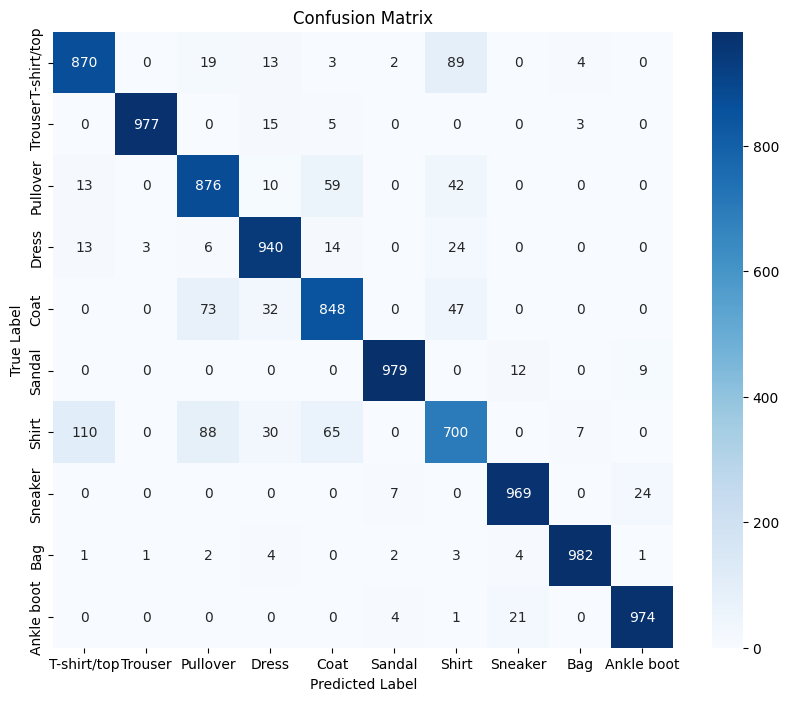


=== Prediction Confidence Analysis ===


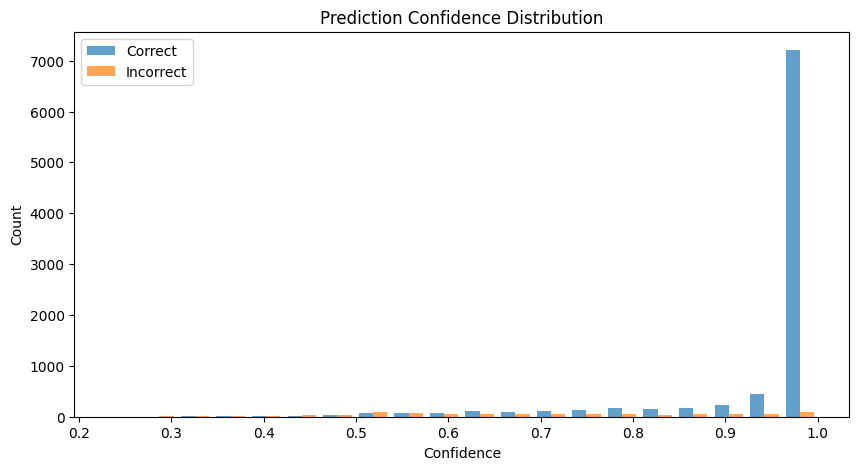

Average confidence for correct predictions: 0.953
Average confidence for incorrect predictions: 0.699
Overall average confidence: 0.930


In [13]:
analysis_results = pipeline.analyze_model()

#### ANALYSIS OF PRELIMINARY RESULTS: 

**Most categories show strong diagonal values (correct predictions), particularly:**

Ankle boots (971 correct)
Trouser (958 correct)
Bag (963 correct)
Sandal (970 correct)



##### Notable Confusion Patterns:

**Shirt-related confusions:**

T-shirt/top is often confused with Shirt (64 cases)
Shirt is frequently mistaken for T-shirt/top (156 cases)
This suggests the model has difficulty distinguishing between different types of upper body garments


**Upper garment mix-ups:**

Pullover, Coat, and Shirt show mutual confusion
Pullover is mistaken for Coat (86 cases) and Shirt (83 cases)
Coat is confused with Shirt (88 cases)


**Footwear distinctions:**

Sneaker and Ankle boot show some mutual confusion (24/60 cases)
Sandal is well-distinguished from other footwear



**Overall Assessment:**

The model performs quite well, with strong diagonal values indicating good accuracy
Most confusions occur between visually similar categories (e.g., different types of tops)
The model is particularly good at identifying distinct categories like bags and trousers
The main area for improvement would be better discrimination between similar upper body garments

#### PLANNED IMPROVEMENT OF MODEL: 

**Attention Mechanism Implementation:**

This would specifically help with the T-shirt/Shirt/Pullover/Coat confusion (your largest source of errors)
The attention layer can learn to focus on discriminative features like:

Collar details (distinguish T-shirts from shirts)
Fabric texture patterns (separate pullovers from coats)
Sleeve structures (differentiate between all upper body garments)

**Focal Loss Implementation:**

This would help the model focus on the hard-to-classify examples
Particularly useful since your confusion matrix shows most classes are well-classified except for specific challenging cases
The gamma parameter can be tuned based on your specific confusion patterns